IMPORT NEEDED LIBRARIES

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load the data

In [ ]:
Train_df = '/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAIN TUMOR DETECTION WITH EFFICIENT NET/data/Training'

filepaths = []
labels = []
folds = os.listdir(Train_df)
for fold in folds:
    FoldPath = os.path.join(Train_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 1615/1615 [00:00<00:00, 242814.67it/s]


In [ ]:
print(len(filepaths))
print(len(labels))

5732
5732


In [ ]:
print(labels[-1])

notumor


In [ ]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [ ]:
df_train = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [ ]:
df_train.head()

,filepath,label
0,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,meningioma
1,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,meningioma
2,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,meningioma
3,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,meningioma
4,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,meningioma


In [ ]:
color = ['#9AA6B2','#BCCCDC','#D9EAFD','#F8FAFC']

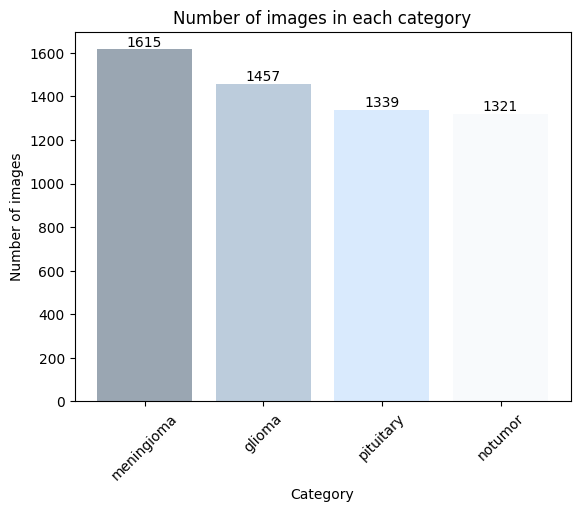

In [ ]:
fig, ax = plt.subplots()
bars = ax.bar(df_train['label'].unique(), df_train['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

In [ ]:
df_train.sample(5)

,filepath,label
1483,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,glioma
3161,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,pituitary
5496,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,notumor
3872,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,pituitary
5678,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,notumor


In [ ]:
Test_df = '/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAIN TUMOR DETECTION WITH EFFICIENT NET/data/Testing'

filepaths = []
labels = []
folds = os.listdir(Test_df)
for fold in folds:
    FoldPath = os.path.join(Test_df, fold)
    files = os.listdir(FoldPath)
    for file in tqdm(files):
        filepath = os.path.join(FoldPath,file)
        filepaths.append(filepath)
        labels.append(fold)

100%|██████████| 300/300 [00:00<00:00, 87018.76it/s]


In [ ]:
print(len(filepaths))
print(len(labels))

1311
1311


In [ ]:
print(np.unique(labels))

['glioma' 'meningioma' 'notumor' 'pituitary']


In [ ]:
 df_test = pd.DataFrame(
    data = {
        'filepath': filepaths,
        'label': labels
    }
)

In [ ]:
df_test.head()

,filepath,label
0,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,glioma
1,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,glioma
2,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,glioma
3,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,glioma
4,/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAI...,glioma


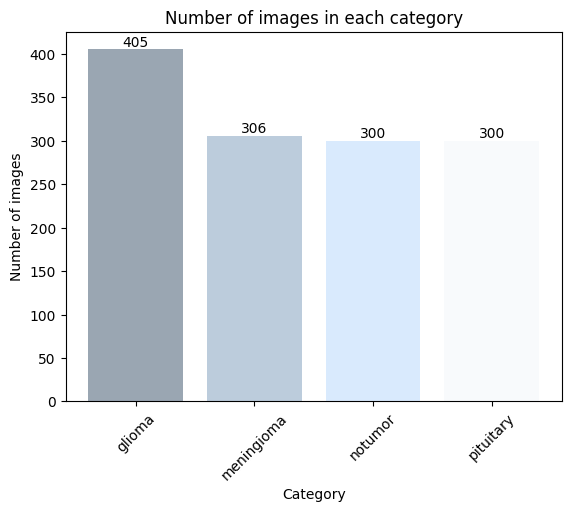

In [ ]:
fig, ax = plt.subplots()
bars = ax.bar(df_test['label'].unique(), df_test['label'].value_counts(),color=color)
ax.bar_label(bars)
plt.title('Number of images in each category')
plt.xlabel('Category')
plt.ylabel('Number of images')
plt.xticks(rotation=45)

plt.show()

Split Data into train, test, valid

In [ ]:
valid_ts, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [ ]:
tr_gen = ImageDataGenerator(rescale=1/255)
ts_gen = ImageDataGenerator(rescale=1/255)
batchsize = 32
img_size = (224,224)

In [ ]:
gen_train = tr_gen.flow_from_dataframe(df_train, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_valid = ts_gen.flow_from_dataframe(valid_ts, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=True,color_mode='rgb')
gen_test = ts_gen.flow_from_dataframe(df_test, x_col='filepath', y_col='label', target_size=img_size, class_mode='categorical', batch_size=batchsize, shuffle=False ,color_mode='rgb')

Found 5732 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
class_dict = gen_train.class_indices

USING A PRETRAINED MODEL (EfficientNet)

In [ ]:
base_model = tf.keras.applications.EfficientNetB3(
    include_top=False,
    weights="imagenet",
    input_shape=(img_size[0],img_size[1],3),
    pooling='max',
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
ModelPretrained = Sequential([
    base_model,

    Dense(256 , activation='relu'),
    Dropout(0,3),
    Dense(4, activation='softmax')

])
ModelPretrained.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history_Final = ModelPretrained.fit(
    gen_train,
    epochs=5,
    validation_data=gen_valid,
    verbose=1,

)

Epoch 1/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 2253s 11s/step - accuracy: 0.7852 - loss: 1.5556 - val_accuracy: 0.1618 - val_loss: 1.8847
Epoch 2/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 105s 279ms/step - accuracy: 0.9717 - loss: 0.0873 - val_accuracy: 0.3328 - val_loss: 2.3462
Epoch 3/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 280ms/step - accuracy: 0.9814 - loss: 0.0584 - val_accuracy: 0.4550 - val_loss: 2.4887
Epoch 4/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 279ms/step - accuracy: 0.9851 - loss: 0.0425 - val_accuracy: 0.8595 - val_loss: 0.3630
Epoch 5/5
180/180 ━━━━━━━━━━━━━━━━━━━━ 84s 291ms/step - accuracy: 0.9947 - loss: 0.0192 - val_accuracy: 0.9908 - val_loss: 0.0262


TESTING AND EVALUATION

In [ ]:
train_score = ModelPretrained.evaluate(gen_train, verbose=1)
valid_score = ModelPretrained.evaluate(gen_valid, verbose=1)
test_score = ModelPretrained.evaluate(gen_test, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 204ms/step - accuracy: 0.9964 - loss: 0.0121
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - accuracy: 0.9827 - loss: 0.0341
21/21 ━━━━━━━━━━━━━━━━━━━━ 275s 14s/step - accuracy: 0.9840 - loss: 0.0632
Train Loss: 0.0125
Train Accuracy: 99.63%
--------------------
Validation Loss: 0.0262
Validation Accuracy: 99.08%
--------------------
Test Loss: 0.0552
Test Accuracy: 98.63%


In [ ]:
ModelPretrained.save('Model Final Brain Tumor.h5')

In [ ]:
import keras.saving

keras.saving.save_model(ModelPretrained, 'Model2 Final Brain Tumor.keras')


In [41]:
print(ModelPretrained.class_indices)

AttributeError: 'Sequential' object has no attribute 'class_indices'

Visualize Model Perfomance

In [ ]:
preds = ModelPretrained.predict(gen_test)
y_pred = np.argmax(preds, axis=1)

21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 661ms/step


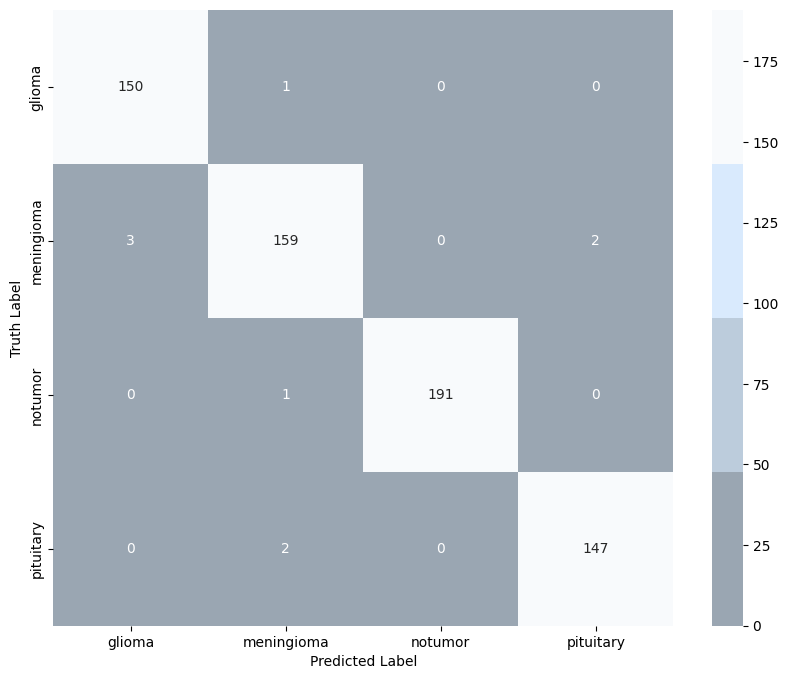

In [ ]:
cm = confusion_matrix(gen_test.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

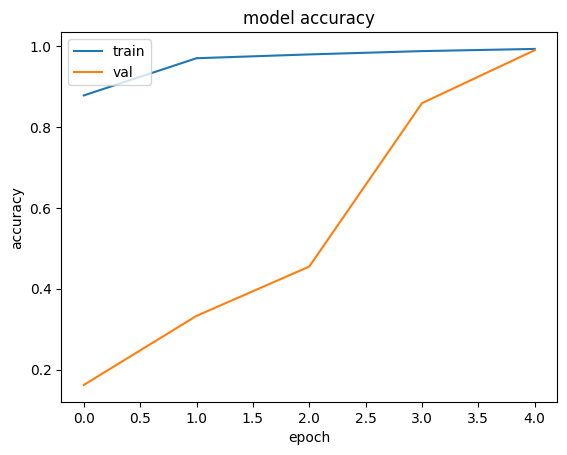

In [ ]:
plt.plot(history_Final.history['accuracy'])
plt.plot(history_Final.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

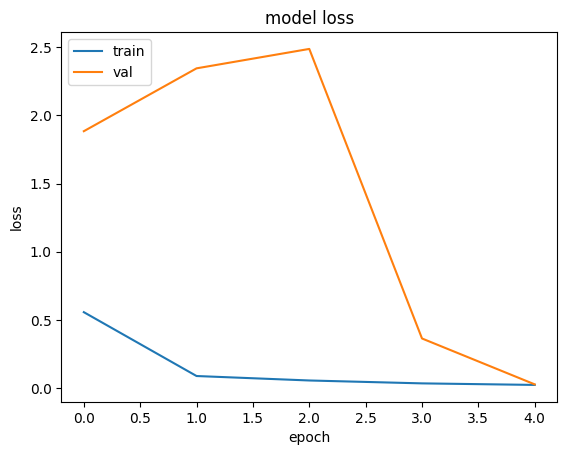

In [39]:
plt.plot(history_Final.history['loss'])
plt.plot(history_Final.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [1]:
def predict(img_path):


    label = list(class_dict.keys())

    plt.figure(figsize=(12, 12))
    img = Image.open(img_path)
    resized_img = img.resize((224, 224))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = ModelPretrained.predict(img)
    probs = list(predictions[0])
    labels = label
    plt.subplot(2, 1, 1)
    plt.imshow(resized_img)
    plt.subplot(2, 1, 2)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


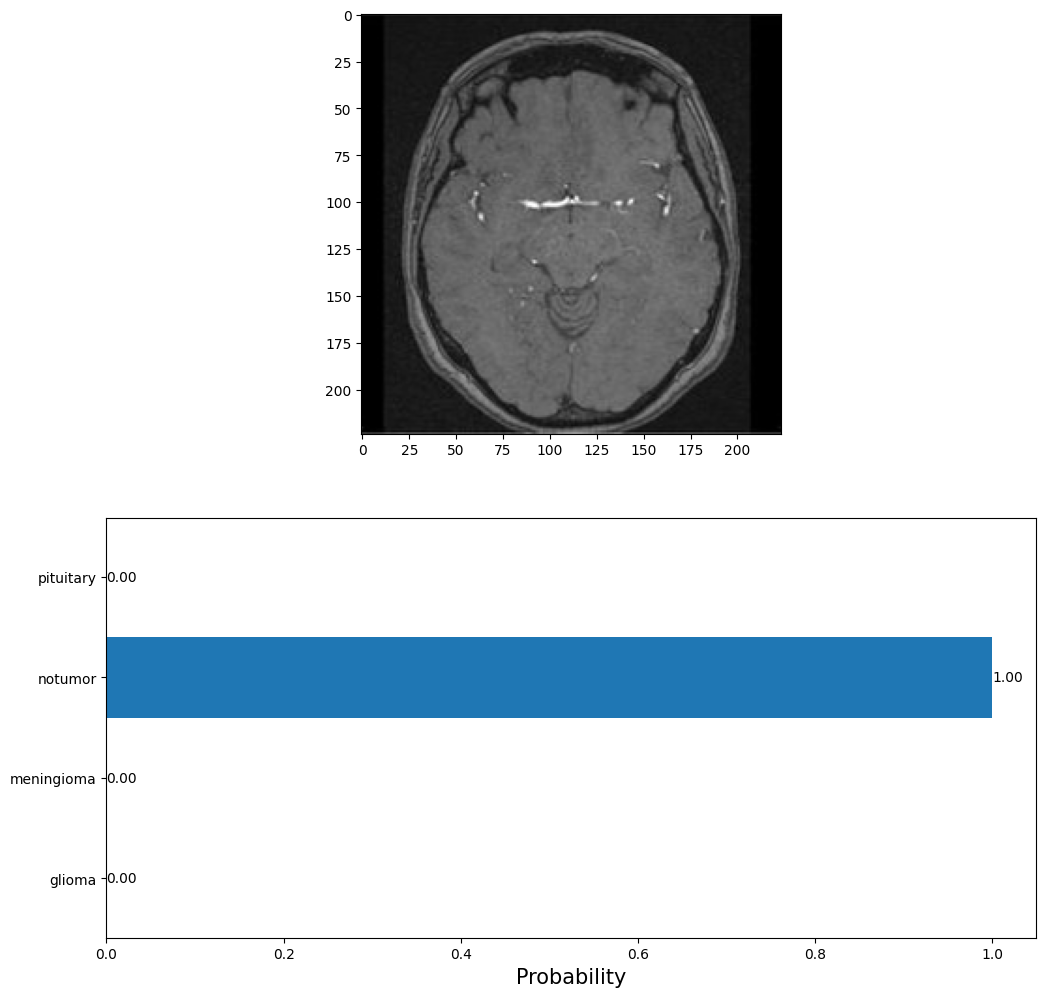

In [ ]:
predict('/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAIN TUMOR DETECTION WITH EFFICIENT NET/data/Testing/notumor/Te-no_0017.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


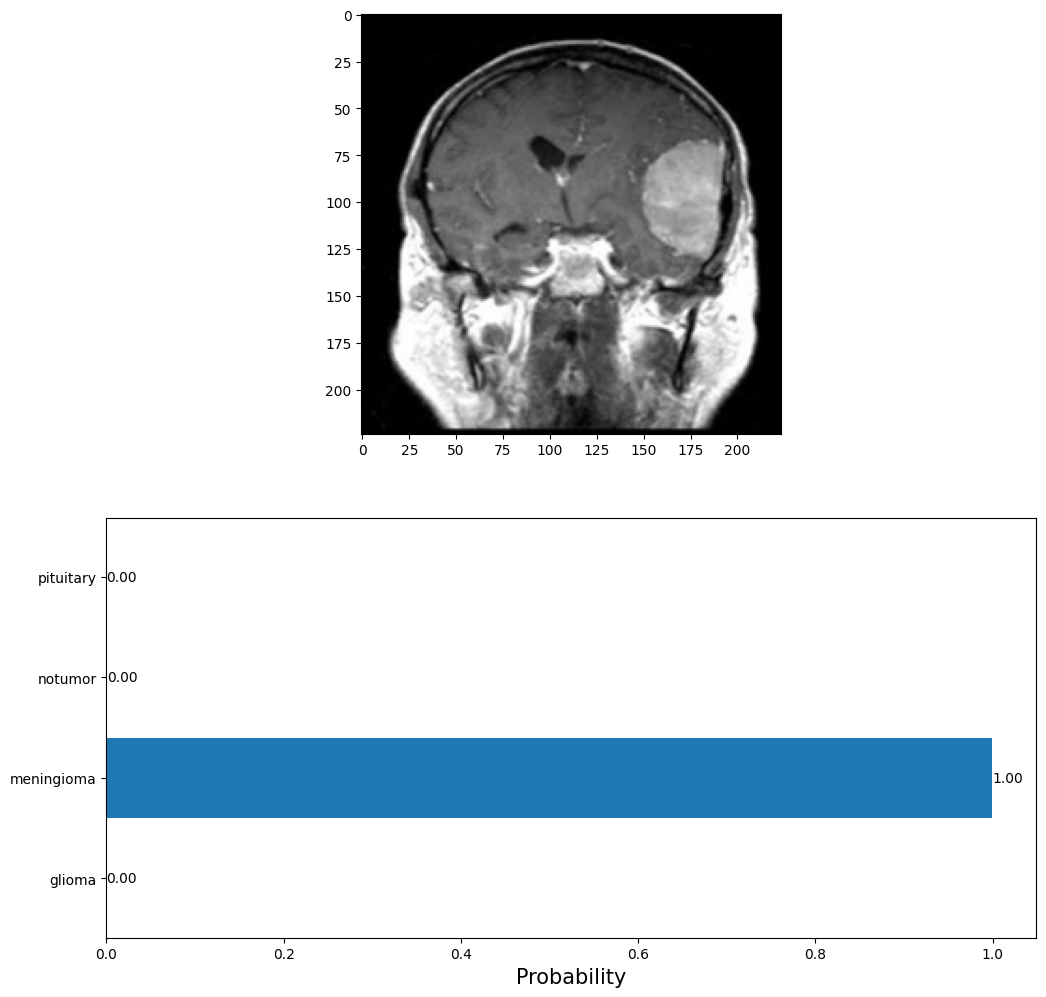

In [ ]:
predict('/content/drive/MyDrive/PORTFOLIO PROJECTS/BRAIN TUMOR DETECTION WITH EFFICIENT NET/data/Testing/meningioma/Te-me_0016.jpg')

In [40]:
label = list(class_dict.keys())
print(label)

['glioma', 'meningioma', 'notumor', 'pituitary']
